In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import Affine
from rasterio.enums import Resampling
import pandas as pd

import pds4_tools
from osgeo import gdal

from scipy import signal
from scipy.ndimage import gaussian_filter

from cmcrameri import cm

In [2]:
def tiff2numpy(file):
    inds = rasterio.open(file)
    data = inds.read(1)
    inds.close()
    return data.astype(np.float32)

def resample(infile, height_scale_factor, width_scale_factor):
   
    with rasterio.open(infile) as dataset:

    # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * height_scale_factor),
                int(dataset.width * width_scale_factor)
            ),
            resampling=Resampling.bilinear
        )

        # scale image transform
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]),
            (dataset.height / data.shape[-2])
        )        
        return data[0]

In [3]:
year = 2015
tessera = "sudenitsa"
folder = "data" + str(year) + "/Clip_tessera_" +str(year)+"/"
cprfile = folder+tessera+"_cpr_norm.tif"
# incifile = folder+tessera+"_inc.tif"
ocpfile = folder+tessera+"_ocp_filt_norm.tif"
scpfile = folder+tessera+"_scp_filt_norm.tif"
emisfile = folder+tessera+"_emis.tif"
topofile = folder+tessera+"_topo.tif"
reffile = folder+tessera+"_ref.tif"
rmssfile = folder+tessera+"_rmsslope.tif"

In [4]:
cpr = tiff2numpy(cprfile)
# inci = tiff2numpy(incifile)
ocp = tiff2numpy(ocpfile)
scp = tiff2numpy(scpfile)
emis = tiff2numpy(emisfile)
ref = tiff2numpy(reffile)
rmss = tiff2numpy(rmssfile)
topo = (tiff2numpy(topofile) + 6051000) / 1e3
print(np.nanmin(topo), np.nanmax(topo))
cpr = tiff2numpy(cprfile)

ht_scale = emis.shape[0]/cpr.shape[0]
wid_scale = emis.shape[1]/cpr.shape[1]

## resampling CPR before opening
cpr_r = resample(cprfile, ht_scale, wid_scale)
scp_r = resample(scpfile, ht_scale, wid_scale)
ocp_r = resample(ocpfile, ht_scale, wid_scale)
# inci_r = resample(incifile, ht_scale, wid_scale)

6049.677 6058.379


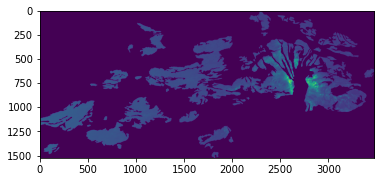

In [5]:
plt.imshow(scp)

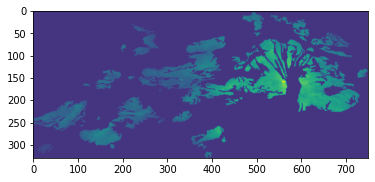

In [6]:
plt.imshow(topo)

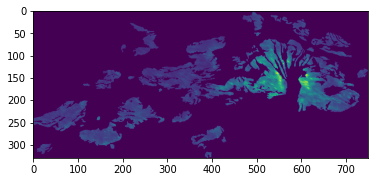

In [7]:
plt.imshow(ref)

In [8]:
print(emis.shape, scp_r.shape, topo.shape, ref.shape)
print(np.nanmax(cpr_r), np.nanmin(cpr_r), np.nanmean(cpr_r))
print(np.min(topo))

(329, 750) (329, 750) (329, 750) (329, 750)
0.4913839 0.0 0.051567517
6049.677


In [9]:
# removing sudenitsa 2015 pixels too close to the limb
# if (tessera == "sudenitsa") & (year == 2015):
#     cols = scp_r.shape[1]
#     clip_col_range = range(int(cols/4),cols-1)
    
#     ocp_r = ocp_r[:, clip_col_range]
#     scp_r = scp_r[:, clip_col_range]
#     cpr_r = cpr_r[:, clip_col_range]
#     emis = emis[:, clip_col_range]
#     topo = topo[:, clip_col_range]
#     inci = inci[:, clip_col_range]

In [10]:
cond = (np.abs(cpr_r)>2.0) | (emis<0.0)
topo[cond] = np.nan 
emis[cond] = np.nan
cpr_r[cond] = np.nan
scp_r[cond] = np.nan
ocp_r[cond] = np.nan

In [11]:
print(np.nanmax(cpr_r), np.nanmin(cpr_r), np.nanmean(cpr_r))
# print(np.nanmax(ocp1d), np.nanmin(ocp1d), np.nanmean(ocp1d))
# print(np.nanmax(scp1d), np.nanmin(scp1d), np.nanmean(scp1d))

0.4913839 0.0 0.051567517


In [12]:
cpr1d = cpr_r.ravel()
# inci1d = inci_r.ravel()
ocp1d = ocp_r.ravel()
scp1d = scp_r.ravel()
emis1d = emis.ravel()
topo1d = topo.ravel()
ref1d = ref.ravel()
rmss1d = rmss.ravel()

In [13]:
mag_df = pd.DataFrame(np.array([topo1d, emis1d, ref1d, rmss1d, cpr1d, ocp1d, scp1d]).T, columns = ["Elevation", "Emissivity", "Reflectivity", "RMS slope", "CPR", "OC", "SC"])
mag_df.dropna()

,Elevation,Emissivity,Reflectivity,RMS slope,CPR,OC,SC
0,6051.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6051.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6051.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6051.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6051.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
246745,6051.0,0.0,0.0,0.0,0.0,0.0,0.0
246746,6051.0,0.0,0.0,0.0,0.0,0.0,0.0
246747,6051.0,0.0,0.0,0.0,0.0,0.0,0.0
246748,6051.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# mag_df = mag_df[mag_df['OC'] != 9999.0]
mag_df = mag_df[mag_df['Emissivity'] > 0]
mag_df = mag_df[mag_df['Reflectivity'] > 0]
mag_df = mag_df[mag_df['SC'] > 0]
mag_df = mag_df[mag_df['OC'] > 0]

In [15]:
mag_df = mag_df[mag_df['OC'] < 4]
mag_df = mag_df[mag_df['SC'] < 15]
# mag_df = mag_df[mag_df['Elevation'] > 6040]

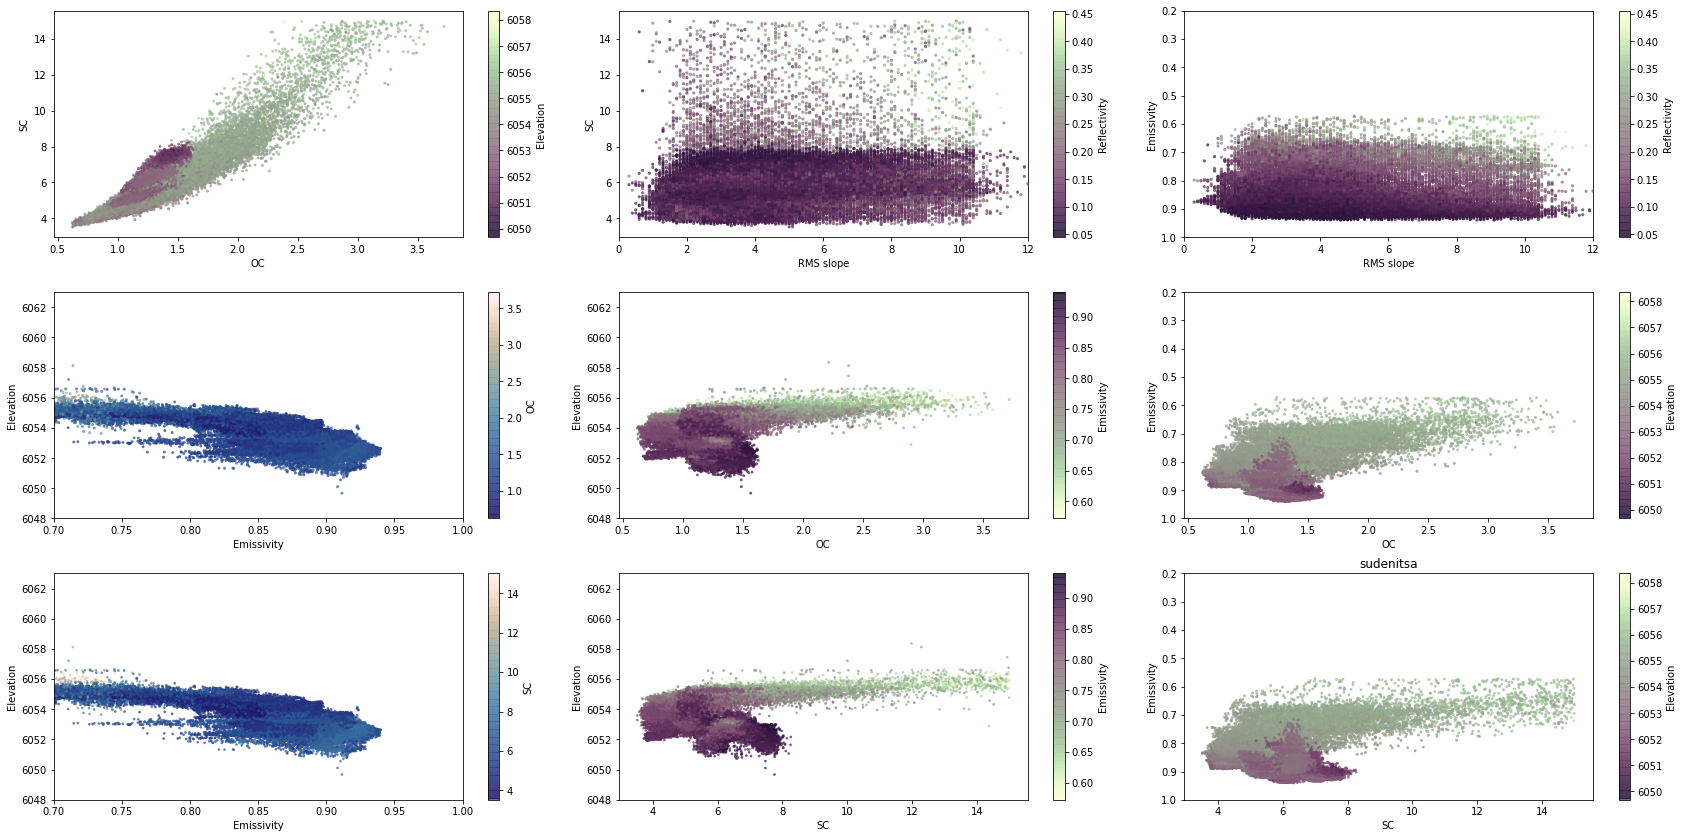

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(24, 12)
cmap = cm.lapaz
ecmap = cm.tokyo_r
elcmap = cm.tokyo
    
    
mag_df.plot.scatter('OC', 'SC', c = 'Elevation', cmap=elcmap, alpha = 0.6, s=4, ax = ax[0,0])
mag_df.plot.scatter('RMS slope', 'SC', c = 'Reflectivity', cmap=elcmap, alpha = 0.6, s=5, ax = ax[0,1])
ax[0,1].set_xlim(0, 12)
# ax[0,1].set_ylim(0.0, 0.8)
mag_df.plot.scatter('RMS slope', 'Emissivity', c = 'Reflectivity',  cmap=elcmap, alpha = 0.6, s=5,  ax = ax[0,2])
ax[0,2].set_xlim(0, 12)
ax[0,2].set_ylim(0.2, 1)
ax[0,2].set_ylim(ax[0,2].get_ylim()[::-1])

mag_df.plot.scatter('Emissivity', 'Elevation', c = 'OC', cmap=cmap, alpha = 0.6, s=4, ax = ax[1,0])
ax[1,0].set_xlim(0.7, 1)
ax[1,0].set_ylim(6048, 6063)
mag_df.plot.scatter('OC', 'Elevation', c = 'Emissivity', cmap=ecmap, alpha = 0.6, s=4, ax = ax[1,1])
ax[1,1].set_ylim(6048, 6063)
mag_df.plot.scatter('OC', 'Emissivity',  c = 'Elevation', cmap=elcmap, alpha = 0.6, s=4, ax = ax[1,2])
ax[1,2].set_ylim(0.2, 1)
ax[1,2].set_ylim(ax[1,2].get_ylim()[::-1])
# ax[0,0].set_ylim(mag_df.Elevation.min() - 1, mag_df.Elevation.max() + 1)

mag_df.plot.scatter('Emissivity', 'Elevation', c = 'SC', cmap=cmap, alpha = 0.6, s=3, ax = ax[2,0])
ax[2,0].set_xlim(0.7, 1)
ax[2,0].set_ylim(6048, 6063)
mag_df.plot.scatter('SC', 'Elevation', c = 'Emissivity', cmap=ecmap, alpha = 0.6, s=3, ax = ax[2,1])
ax[2,1].set_ylim(6048, 6063)
mag_df.plot.scatter('SC', 'Emissivity', c = 'Elevation', cmap=elcmap, alpha = 0.6, s=4, ax = ax[2,2])
ax[2,2].set_ylim(0.2, 1)
ax[2,2].set_ylim(ax[2,2].get_ylim()[::-1])




fig.tight_layout(pad=2.0)
# plt.savefig(tessera+'2015.png', bbox_inches='tight')
plt.title(tessera, loc = "center")
plt.show()

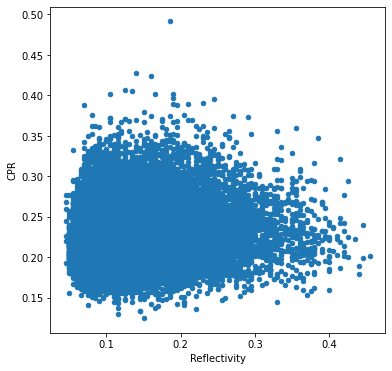

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(6,6)
cmap = cm.hawaii

mag_df.plot.scatter('Reflectivity', 'CPR', ax= ax)
plt.show()